In [115]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd

from scipy.optimize     import minimize, curve_fit
from scipy.stats        import chi2
from math               import pi
from matplotlib.ticker  import MaxNLocator
from matplotlib         import gridspec

import scipy
import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

## Task 1

In [2]:
# define the given function
def f(vars):
    """2D six-hump camelback function"""
    x = vars[0]
    y = vars[1]
    return (4-2.1*x**2+x**4/3)*x**2 + x*y + (4*y**2-4)*y**2

# restrict the x and y axis as suggested
xgrid = np.linspace(-2, 2, 500)
ygrid = np.linspace(-1, 1, 500)

# numpy meshgrid to build the 2D grid
X, Y = np.meshgrid(xgrid, ygrid)

# compute the function given the xy grid points
Z = f((X, Y))

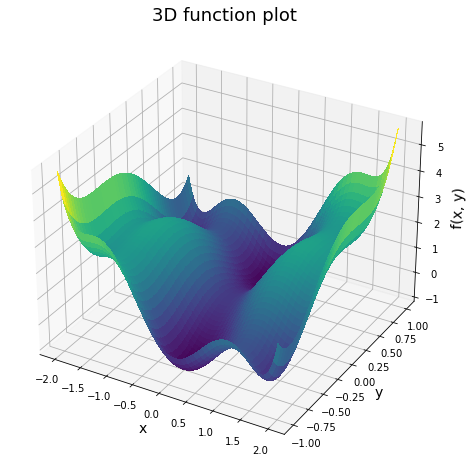

In [3]:
# 3D PLOT

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

im3d = ax.plot_surface(X, Y, Z, cmap="viridis", antialiased=False)

ax.set_title("3D function plot", fontsize=18)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
ax.set_zlabel("f(x, y)", fontsize=14)

plt.show()

In [4]:
# list of initial guesses for function minimization
initial_guesses = [
    [0, 0],
    [0, -0.75],
    [0, 0.75],
    [1, 0],
    [-1, 0]
]

# minimization of the function given a set of initial guesses
minima = [minimize(f, x0=guess) for guess in initial_guesses]

for min, guess in zip(minima, initial_guesses):
    x = min.x[0]
    y = min.x[1]
    z = min.fun
    xguess = guess[0]
    yguess = guess[1]

    print(f"Initial guess: ({xguess:.2f}, {yguess:.2f}) \t ----> \t minimum: {z:.2f} at ({x:.2f}, {y:.2f})")


Initial guess: (0.00, 0.00) 	 ----> 	 minimum: 0.00 at (0.00, 0.00)
Initial guess: (0.00, -0.75) 	 ----> 	 minimum: -1.03 at (0.09, -0.71)
Initial guess: (0.00, 0.75) 	 ----> 	 minimum: -1.03 at (-0.09, 0.71)
Initial guess: (1.00, 0.00) 	 ----> 	 minimum: -1.03 at (0.09, -0.71)
Initial guess: (-1.00, 0.00) 	 ----> 	 minimum: -1.03 at (-0.09, 0.71)


In [5]:
print("There are 2 global minima, and the function evaluated at those points is -1.03")
print("If we choose (0,0) as initial guess the minimization do not converge to neither one of the two minima")

There are 2 global minima, and the function evaluated at those points is -1.03
If we choose (0,0) as initial guess the minimization do not converge to neither one of the two minima


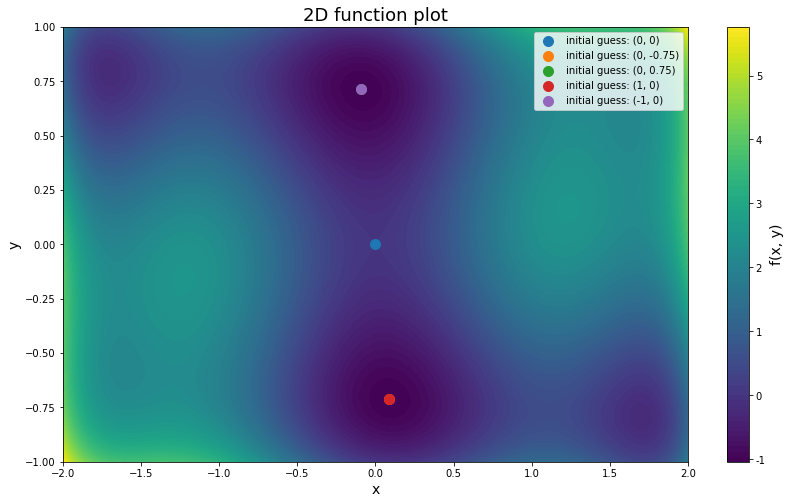

In [14]:
# 2D PLOT WITH MINIMA

fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(111)

im = ax.contourf(X, Y, Z, levels=100, origin="lower")
cbar = fig.colorbar(im, ax=ax)

ax.set_title("2D function plot", fontsize=18)
ax.set_xlabel("x", fontsize=14)
ax.set_ylabel("y", fontsize=14)
cbar.ax.set_ylabel("f(x, y)", fontsize=14)
cbar.ax.set_yticks(range(-1, 6))
cbar.ax.set_yticklabels(["{:.0f}".format(i) for i in range(-1, 6)])

# plot minima
for min, guess in zip(minima, initial_guesses):
    ax.scatter(min.x[0], min.x[1], s=100, label=f"initial guess: ({guess[0]}, {guess[1]})")

ax.legend()
plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

## Task 2

In [44]:
t_max = np.array([17,   19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18])
t_min = np.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]) # cold huh

months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
num_months = np.array(list(range(len(months))))

In [20]:
# we expect temperatures to be periodic throughout the years
# namely we expect higher max and min temperatures in summer and lower temperatures in winter
# let's try with a sine function then

def f(x, A, w, k, c):
    """
    periodic function

    args:
        x : data
        A : amplitude
        w : frequency
        k : phase
        c : offset
    """
    
    return A * np.sin(w*x + k) + c

par_list = ["ampl", "freq", "phase", "offset"]

In [32]:
# initial guesses
p0_min = [(t_min.max() - t_min.min())/2, 2/t_min.shape[0], t_min.argmax(), t_min.mean()]
p0_max = [(t_max.max() - t_max.min())/2, 2/t_max.shape[0], t_max.argmax(), t_max.mean()]

# fitting data
par_max, cov_max = curve_fit(f=f, xdata=num_months, ydata=t_max, p0=p0_max)
par_min, cov_min = curve_fit(f=f, xdata=num_months, ydata=t_min, p0=p0_min)

# computing parameter uncertainties
err_max = np.sqrt(cov_max.diagonal())
err_min = np.sqrt(cov_min.diagonal())

fit_max = list(zip(par_list, par_max, err_max))
fit_min = list(zip(par_list, par_min, err_min))

print("\nMAX TEMPERATURES FIT:")
print()
for n, p, e in fit_max:
    print(f"{n}:\t\t {p:8.3f} +/- {e:6.3f}  \t\t relative error: \t {np.abs(e/p):.2%}")
print()
print("\nMIN TEMPERATURES FIT:")
print()
for n, p, e in fit_min:
    print(f"{n}:\t\t {p:8.3f} +/- {e:6.3f}  \t\t relative error: \t {np.abs(e/p):.2%}")


MAX TEMPERATURES FIT:

ampl:		   10.582 +/-  0.410  		 relative error: 	 3.88%
freq:		    0.592 +/-  0.021  		 relative error: 	 3.58%
phase:		    4.465 +/-  0.126  		 relative error: 	 2.82%
offset:		   27.950 +/-  0.428  		 relative error: 	 1.53%


MIN TEMPERATURES FIT:

ampl:		   25.150 +/-  1.315  		 relative error: 	 5.23%
freq:		    0.601 +/-  0.023  		 relative error: 	 3.83%
phase:		    4.166 +/-  0.143  		 relative error: 	 3.43%
offset:		  -36.713 +/-  1.191  		 relative error: 	 3.24%


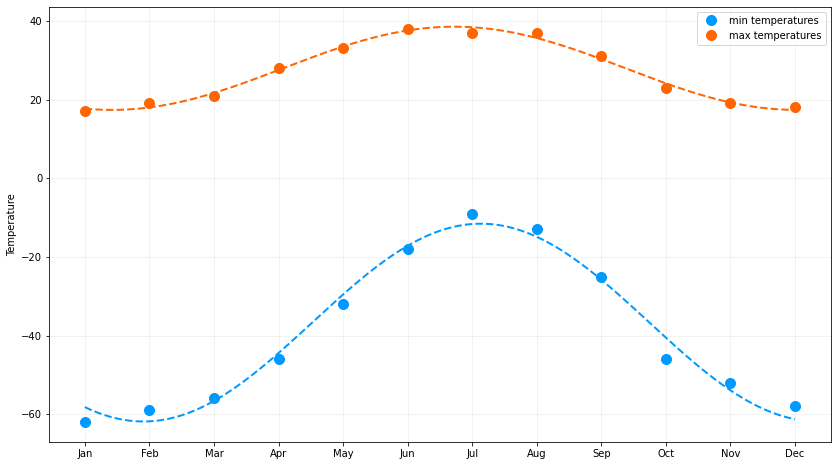

In [35]:
fig, ax = plt.subplots(figsize=(14,8))
ax.grid(which = "both", alpha=0.2)

ax.plot(months, t_min, color="#009AFF", lw=3, ls="none", marker="o", markersize=10, label="min temperatures")
ax.plot(months, t_max, color="#ff6500", lw=3, ls="none", marker="o", markersize=10, label="max temperatures")

grid = np.linspace(num_months[0], num_months[-1], 500)
ax.plot(grid, f(grid, *par_min), color="#009AFF", lw=2, ls="dashed")
ax.plot(grid, f(grid, *par_max), color="#ff6500", lw=2, ls="dashed")

ax.set_ylabel("Temperature")

ax.legend()
plt.show()

In [47]:
print("The two fit look reasonable. Without knowing uncertainties of the measurements, we cannot be that much quantitative about that though.")
print("However the fitted function approximates the behaviour of datapoints reasonably well! Let's check the correlation coefficient:")

ssr_max = np.sum( ( f(num_months, *par_max) - t_max )**2 )
tss_max = np.sum( ( t_max.mean() - t_max )**2 )
rsq_max = 1. - ssr_max / tss_max

ssr_min = np.sum( ( f(num_months, *par_min) - t_min )**2 )
tss_min = np.sum( ( t_min.mean() - t_min )**2 )
rsq_min = 1. - ssr_min / tss_min

print()
print("MAX TEMPERATURES:")
print(f"R^2 = {rsq_max:.4f}")
print()
print("MIN TEMPERATURES:")
print(f"R^2 = {rsq_min:.4f}")
print()
print("Since the two R^2 are really close to 1 we deduce that the fit is satisfactory.\n\n")

print("To tell whether the time offset is the same we check for compatibility between the two phase parameters.\n")

def comp(a, erra, b, errb):
    """compatibility between two estimates with uncertainties"""
    return np.abs(a-b)/np.sqrt(erra**2+errb**2)

phase_max = fit_max[-2]
pahse_min = fit_min[-2]

c = comp(phase_max[1], phase_max[2], pahse_min[1], pahse_min[2])

print(f"The two time offsets show a compatibility of {c:.2f}, which shows that the two are reasonably compatible although quite different.")

The two fit look reasonable. Without knowing uncertainties of the measurements, we cannot be that much quantitative about that though.
However the fitted function approximates the behaviour of datapoints reasonably well! Let's check the correlation coefficient:

MAX TEMPERATURES:
R^2 = 0.9883

MIN TEMPERATURES:
R^2 = 0.9787

Since the two R^2 are really close to 1 we deduce that the fit is satisfactory.


To tell whether the time offset is the same we check for compatibility between the two phase parameters.

The two time offsets show a compatibility of 1.57, which shows that the two are reasonably compatible although quite different.


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

## Task 3

In [130]:
data_file = "./data/residuals_261.pkl"
data = np.load(data_file, allow_pickle=True)
df = pd.DataFrame(data.item())

# clean dataset
df = df[abs(df["residuals"]) < 2.]

x=df["residuals"]

In [131]:
BINS = 50
hist, edges = np.histogram(x, bins=BINS)

# extract information on the binning
binswidth = edges[1]-edges[0]
bincenters = 0.5 * (edges[1:]+edges[:-1])

# poisson errors
err = np.sqrt(hist)

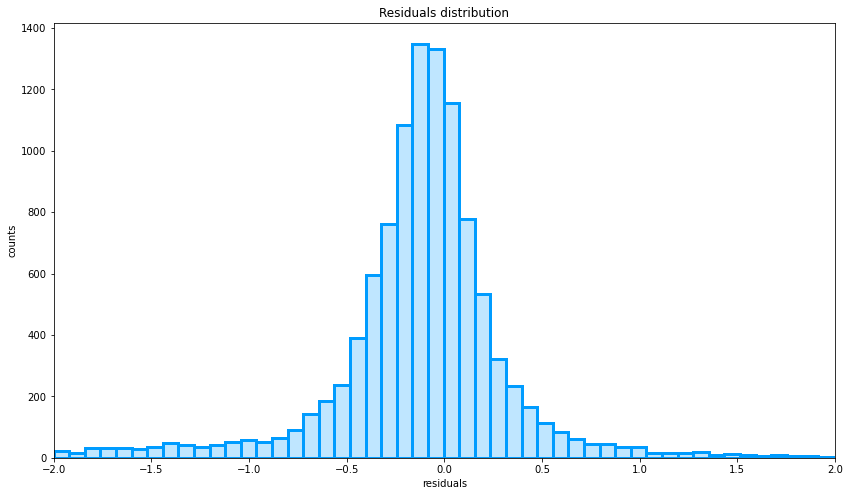

In [132]:
# let's look at the distribution first

fig, ax = plt.subplots(figsize=(14,8))

# histogram
sns.histplot(
    x=edges[:-1],
    weights=hist,
    bins=edges,
    color="#aadeff",
    edgecolor="#009cff",
    lw=3,
    label="residuals distribution",
    ax=ax
)


ax.set_xlim(-2, 2)

ax.set_title("Residuals distribution")
ax.set_xlabel("residuals")
ax.set_ylabel("counts")

plt.show()

In [133]:
# residuals do look kind of gaussian distributed
# but the asymmetry in tails is noticeable
# a gaussian fit would not really be satisfactory in this case
# however, it deserves a shot!

def f(x, A, mu, sigma):
    """gaussian function"""
    return A * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sigma, 2.)))

par_list = ["scale", "mean", "sigma"]

In [134]:
# initial guesses
p0 = [hist.max(), edges[hist.argmax()], x.std()]

# fitting data
par, cov = curve_fit(f=f, xdata=edges[:-1], ydata=hist, p0=p0, sigma=err, absolute_sigma=True)

# parameter uncertainties
fit_err = np.sqrt(cov.diagonal())

fit = list(zip(par_list, par, fit_err))

xgrid=np.linspace(edges[0], edges[-1], 500)
func = f(edges[:-1], *par)
res = hist - func

# compute chi2 
chisq = np.sum((res/err)**2)
# number of degrees of freedom
ndf=hist.shape[0]-par.shape[0]
# p-value
pval = chi2.sf(chisq, df=ndf)

print("\nGAUSSIAN FIT:")
print()
for n, p, e in fit:
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")

print(f"\nchi2 / ndf: \t {chisq:.2f} / {ndf} \t---->\t pval = {pval:.3e}")


GAUSSIAN FIT:

scale:		 1119.60176 +/- 15.18720  		 relative error: 	 1.356%
mean:		   -0.13104 +/- 0.00276  		 relative error: 	 2.103%
sigma:		    0.26668 +/- 0.00234  		 relative error: 	 0.879%

chi2 / ndf: 	 1117.07 / 47 	---->	 pval = 3.374e-203


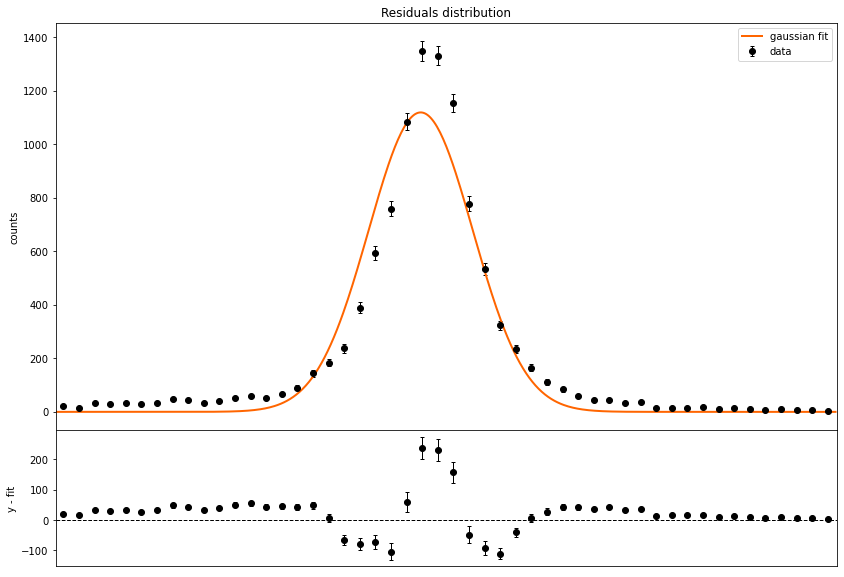

In [137]:
fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex = ax1)

# histogram
ax1.errorbar(
    bincenters,
    hist,
    yerr=err,
    marker="o",
    ls="none",
    color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    label="data",
)

ax1.plot(xgrid, f(xgrid, *par), lw=2, color="#ff6500", label="gaussian fit")

ax1.set_xlim(-2, 2)

ax1.set_title("Residuals distribution")
ax1.set_ylabel("counts")
ax1.set_xticks([])

ax1.legend()

ax2.errorbar(
    bincenters,
    res,
    yerr=err,
    marker="o",
    ls="none",
    color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    label="data",
)

ax2.axhline(color = 'black', linewidth = 1, linestyle = '--')
ax2.set_ylabel("y - fit")

plt.subplots_adjust(hspace=.0)

plt.show()

In [87]:
print("The p-value is extremely low, showing a poor compatibility between the fitted function and the actual distribution of data.")
print("We can easily see that the tails of the data distribution are larger than the fitted function. Moreover the left one is greater than the right one.")
print("We can deduce that the gauss function may not be the best choice for representing the data distribution. However, different functons such as the Breit-Wigner do fit even worse.")
print("Assuming that data is not affected by systematic uncertainties, residuals should follow a gaussian distribution.") 
print("Here we see that data looks like gaussian, but the low p-value tells us that probably there are some systematics that were not taken into account, or the former fitted function may not be the perfect choice.")

The p-value is extremely low, showing a poor compatibility between the fitted function and the actual distribution of data.
We can easily see that the tails of the data distribution are larger than the fitted function. Moreover the left one is greater than the right one.
We can deduce that the gauss function may not be the best choice for representing the data distribution. However, different functons such as the Breit-Wigner do fit even worse.
Assuming that data is not affected by systematic uncertainties, residuals should follow a gaussian distribution.
Here we see that data looks like gaussian, but the low p-value tells us that probably there are some systematics that were not taken into account, or the former fitted function may not be the perfect choice.


In [138]:
# we have found that data is not gaussian distributed
# let's try something more fancy: a Voigt distribution

def g(x, A, x0, g0): 
    """
    gaussian function

    Args:
        x  : data
        A  : area under the peak
        x0 : peak center
        g0 : fwhm
    """
    return (A/g0) * np.sqrt( 4*np.log(2) / pi ) * np.exp( -4*np.log(2) * ( (x-x0)/g0 )**2 )

def l(x, A, x0, g0): 
    """
    breit wigner - cauchy - lorentz - ? - function
    
    Args: 
        x  : data 
        A  : area under the peak
        x0 : peak center
        g0 : fwhm
    """
    return ( (2*A)/(pi*g0) ) / ( 1 + 4*( (x-x0)/g0 )**2 )

def voigt(x, A, x0, g0, p):
    """
    voigt function
    """
    return p*l(x, A, x0, g0) + (1-p)*g(x, A, x0, g0)


par_list = [
    "A",
    "x0",
    "g0",
    "p"
]

In [139]:
# initial guesses
prob = 0.5
p0 = [hist.max(), edges[hist.argmax()], x.std(), prob]

# fitting data
par, cov = curve_fit(
    f=voigt, 
    xdata=edges[:-1], 
    ydata=hist, 
    p0=p0, 
    sigma=err, 
    absolute_sigma=True
)

# parameter uncertainties
fit_err = np.sqrt(cov.diagonal())

fit = list(zip(par_list, par, fit_err))

xgrid=np.linspace(edges[0], edges[-1], 500)
func = voigt(edges[:-1], *par)
res = hist - func

# compute chi2 
chisq = np.sum((res/err)**2)
# number of degrees of freedom
ndf=hist.shape[0]-par.shape[0]
# p-value
pval = chi2.sf(chisq, df=ndf)

print("\nGAUSSIAN FIT:")
print()
for n, p, e in fit:
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")

print(f"\nchi2 / ndf: \t {chisq:.2f} / {ndf} \t---->\t pval = {pval:.3e}")


GAUSSIAN FIT:

A:		  863.30721 +/- 8.57279  		 relative error: 	 0.993%
x0:		   -0.13065 +/- 0.00271  		 relative error: 	 2.072%
g0:		    0.48912 +/- 0.00819  		 relative error: 	 1.674%
p:		    0.60193 +/- 0.02064  		 relative error: 	 3.430%

chi2 / ndf: 	 184.19 / 46 	---->	 pval = 1.919e-18


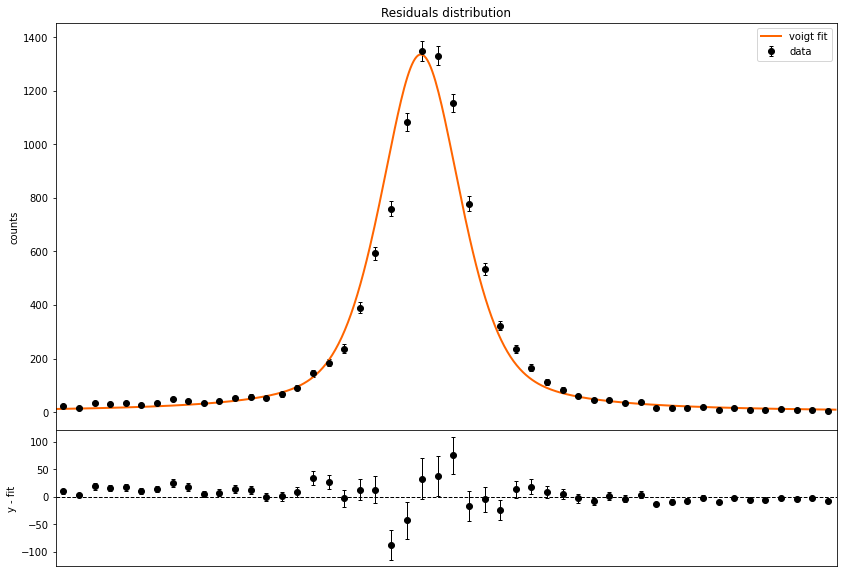

In [140]:
fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex = ax1)

# histogram
ax1.errorbar(
    bincenters,
    hist,
    yerr=err,
    marker="o",
    ls="none",
    color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    label="data",
)

ax1.plot(xgrid, voigt(xgrid, *par), lw=2, color="#ff6500", label="voigt fit")

ax1.set_xlim(-2, 2)

ax1.set_title("Residuals distribution")
ax1.set_ylabel("counts")
ax1.set_xticks([])

ax1.legend()

ax2.errorbar(
    bincenters,
    res,
    yerr=err,
    marker="o",
    ls="none",
    color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    label="data",
)

ax2.axhline(color = 'black', linewidth = 1, linestyle = '--')
ax2.set_ylabel("y - fit")

plt.subplots_adjust(hspace=.0)

plt.show()

In [100]:
print("The fit has improved drastically! The convolution of a gaussian distribution and a lorentz distribution works better.")
print("However, we still notice a slight asymmetry in the fit. Let's get fancier with an asymmetric voigt function!")

The fit has improved drastically! The convolution of a gaussian distribution and a lorentz distribution works better.
However, we still notice a slight asymmetry in the fit. Let's get fancier with an asymmetric voigt function!


In [141]:
def g(x, A, x0, g0, a): 
    """
    gaussian function

    Args:
        x  : data
        A  : area under the peak
        x0 : peak center
        g0 : fwhm
    """
    return (A/((2*g0) / (1 + np.exp( a * (x - x0) )) )) * np.sqrt( 4*np.log(2) / pi ) * np.exp( -4*np.log(2) * ( (x-x0)/((2*g0) / (1 + np.exp( a * (x - x0) )) ) )**2 )

def l(x, A, x0, g0, a): 
    """
    breit wigner - cauchy - lorentz - ? - function
    
    Args: 
        x  : data 
        A  : area under the peak
        x0 : peak center
        g0 : fwhm
    """
    return ( (2*A)/(pi*((2*g0) / (1 + np.exp( a * (x - x0) )) )) ) / ( 1 + 4*( (x-x0)/((2*g0) / (1 + np.exp( a * (x - x0) )) ) )**2 )

def asym_voigt(x, A, x0, g0, p, a): 
    return p*l(x, A, x0, g0, a) + (1-p)*g(x, A, x0, g0, a)

par_list = [
    "A",
    "x0",
    "g0",
    "p",
    "a"
]

In [142]:
# initial guesses
prob = 0.5
asym = 2
p0 = [hist.max(), edges[hist.argmax()], x.std(), prob, 0.5]

# fitting data
par, cov = curve_fit(
    f=asym_voigt, 
    xdata=edges[:-1], 
    ydata=hist, 
    p0=p0, 
    sigma=err, 
    absolute_sigma=True
)

# parameter uncertainties
fit_err = np.sqrt(cov.diagonal())

fit = list(zip(par_list, par, fit_err))

xgrid=np.linspace(edges[0], edges[-1], 500)
func = asym_voigt(edges[:-1], *par)
res = hist - func

# compute chi2 
chisq = np.sum((res/err)**2)
# number of degrees of freedom
ndf=hist.shape[0]-par.shape[0]
# p-value
pval = chi2.sf(chisq, df=ndf)

print("\nGAUSSIAN FIT:")
print()
for n, p, e in fit:
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")

print(f"\nchi2 / ndf: \t {chisq:.2f} / {ndf} \t---->\t pval = {pval:.3e}")


GAUSSIAN FIT:

A:		  878.31638 +/- 8.70156  		 relative error: 	 0.991%
x0:		   -0.11941 +/- 0.00290  		 relative error: 	 2.429%
g0:		    0.47011 +/- 0.00882  		 relative error: 	 1.877%
p:		    0.68570 +/- 0.02326  		 relative error: 	 3.392%
a:		    0.51934 +/- 0.05122  		 relative error: 	 9.862%

chi2 / ndf: 	 75.66 / 45 	---->	 pval = 2.845e-03


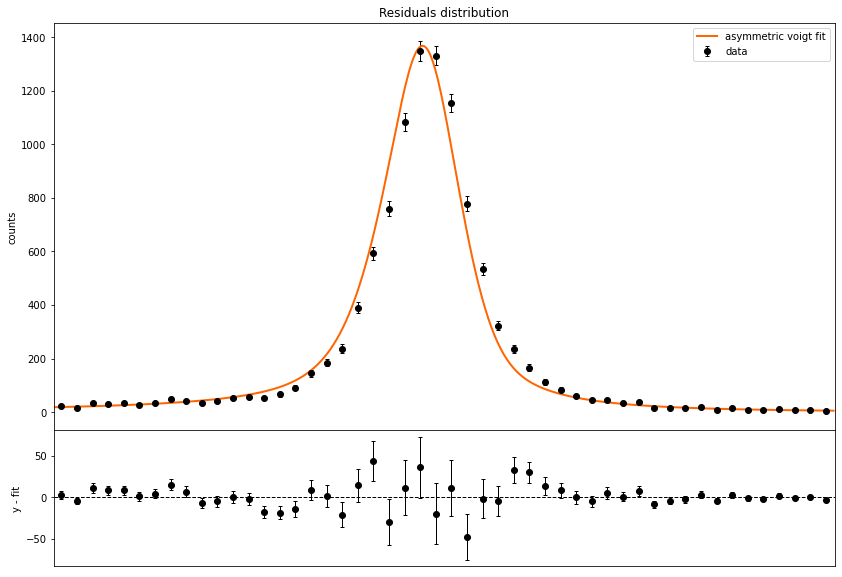

In [143]:
fig = plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(2, 1,height_ratios=[3, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1],sharex = ax1)

# histogram
ax1.errorbar(
    bincenters,
    hist,
    yerr=err,
    marker="o",
    ls="none",
    color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    label="data",
)

ax1.plot(xgrid, asym_voigt(xgrid, *par), lw=2, color="#ff6500", label="asymmetric voigt fit")

ax1.set_xlim(-2, 2)

ax1.set_title("Residuals distribution")
ax1.set_ylabel("counts")
ax1.set_xticks([])

ax1.legend()

ax2.errorbar(
    bincenters,
    res,
    yerr=err,
    marker="o",
    ls="none",
    color="#000000",
    linewidth=0, 
    elinewidth=1, 
    capsize=2, 
    label="data",
)

ax2.axhline(color = 'black', linewidth = 1, linestyle = '--')
ax2.set_ylabel("y - fit")

plt.subplots_adjust(hspace=.0)

plt.show()

In [144]:
print("The fit is not perfect but, at least, resembles the data distribution!") 
print("Let's dive deeper into the goodness of fit:")

The fit is not perfect but, at least, resembles the data distribution!
Let's dive deeper into the goodness of fit:


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is necessary.

## Task 4

In [47]:
def f(x, a, b, c):
    return a*np.cos(2*pi*x + b) + c

par_list1 = ["a", "b", "c"]

def g(x, a, b, c, d):
    return a*np.cos(2*pi*b*x + c) + d

par_list2 = ["a", "b", "c", "d"]

In [3]:
df = pd.read_csv("./data/munich_temperatures_average_with_bad_data.txt", sep=" ", header=None, names=["year", "temperature"])

In [48]:
par1, cov1 = curve_fit(f=f, xdata=df.year, ydata=df.temperature)
par2, cov2 = curve_fit(f=g, xdata=df.year, ydata=df.temperature)

# parameter uncertainties
fit_err1 = np.sqrt(cov1.diagonal())
fit_err2 = np.sqrt(cov2.diagonal())

print("\nFIRST MODEL:\n")
for n, p, e in zip(par_list1, par1, fit_err1):
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")
print()
print("\nSECOND MODEL:\n")
for n, p, e in zip(par_list2, par2, fit_err2):
    print(f"{n}:\t\t {p:10.5f} +/- {e:7.5f}  \t\t relative error: \t {np.abs(e/p):.3%}")


FIRST MODEL:

a:		   -9.88877 +/- 0.13631  		 relative error: 	 1.378%
b:		   12.30923 +/- 0.01385  		 relative error: 	 0.113%
c:		    8.60030 +/- 0.09663  		 relative error: 	 1.124%


SECOND MODEL:

a:		   -9.88899 +/- 0.13641  		 relative error: 	 1.379%
b:		    1.00016 +/- 0.00042  		 relative error: 	 0.042%
c:		   10.23469 +/- 5.25632  		 relative error: 	 51.358%
d:		    8.60105 +/- 0.09665  		 relative error: 	 1.124%


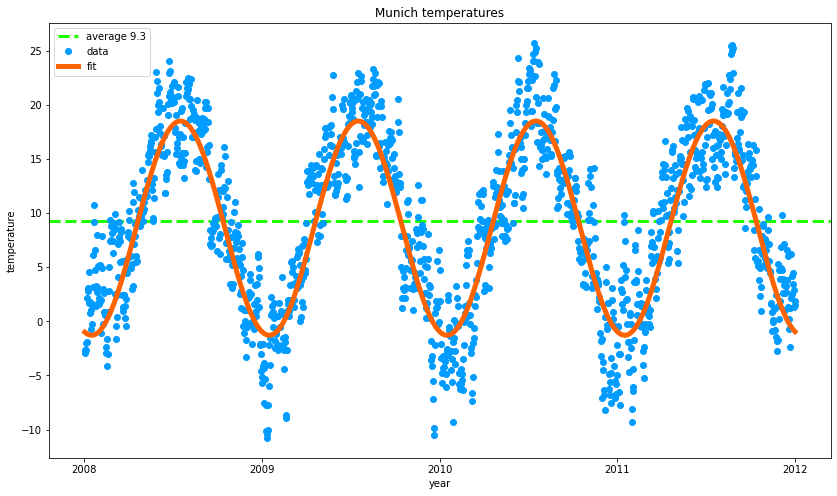

In [30]:
mask = (df.year>2008) & (df.year<2012)
df=df[df.temperature<60] # removing outliers, temperatures above 60 degrees are 100% not reliable... and 60 is a high threshold!

x=df[mask]["year"]
y=df[mask]["temperature"]

avg_temp = y.mean()

fig, ax = plt.subplots(figsize=(14, 8))
ax.axhline(y=avg_temp,  lw=3,   ls="--",                color="#1dff00", label=f"average {avg_temp:.1f}")
ax.plot(x, y,                   ls="none", marker="o",  color="#009cff", label="data")
ax.plot(x, f(x, *par1), lw=5,   ls="-",                 color="#ff6300", label="fit")
# ax.plot(x, g(x, *par2), lw=3)

ax.set_title("Munich temperatures")
ax.set_xlabel("year")
ax.set_ylabel("temperature")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.legend()
plt.show()

In [40]:
print(f"The overall average is given my the mean of the temperatures: {avg_temp:.1f}")
print()
print("The typical daily average values predicted by the model for the coldest and hottest time of year are given by the minimum and maximum values of the cosine:")
print(f"Daily average for the coldest time of the year: {f(x, *par1).min():.1f}")
print(f"Daily average for the hottest time of the year: {f(x, *par1).max():.1f}")
print("\n\n")
print("The b parameter is shifting the cosine along the x axis and allows for more flexibility. Without the b parameter we would need to shift data to have one of its maxima at 0 in order to perform a fit.")
print("'Physically' it is a phase parameter that determine the initial phase of the cosine (not very physical though..)")

The overall average is given my the mean of the temperatures: 9.3

The typical daily average values predicted by the model for the coldest and hottest time of year are given by the minimum and maximum values of the cosine:
Daily average for the coldest time of the year: -1.3
Daily average for the hottest time of the year: 18.5



The b parameter is shifting the cosine along the x axis and allows for more flexibility. Without the b parameter we would need to shift data to have one of its maxima at 0 in order to perform a fit.
'Physically' it is a phase parameter that determine the initial phase of the cosine (not very physical though..)


In [58]:
def FTest(ssr1, ssr2, ndf1, ndf2, n):
    """Fisher F-Test"""
    F = ((ssr1 - ssr2)/(ndf2 - ndf1)) / (ssr2/(n - ndf2))
    CL = 1. - scipy.stats.f.cdf(F, ndf2 - ndf1, n - ndf2)
    print(f"CL: {CL:.3f}, additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

In [57]:
# assuming that RSS is what we called SSR during class i.e. the sum of squared residuals
ssr1 = np.sum((df.temperature - f(df.year, *par1))**2)
ssr2 = np.sum((df.temperature - g(df.year, *par2))**2)

ndf1 = len(par1) - 1 # n of parameters - 1
ndf2 = len(par2) - 1 # n of parameters - 1

CL = FTest(ssr1, ssr2, ndf1, ndf2, y.count())

CL: 0.853, additional parameter necessary: NO
